# Modelling

In [2]:
import os

def get_project_path(relative_path):
    # Get the directory where this script is located
    script_dir = os.path.dirname(os.path.abspath(__file__))
    # Join it with the relative path to get the full path
    return os.path.join(script_dir, relative_path)

In [3]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("LinearRegressionExample") \
    .config("spark.executor.memory", "8G") \
    .config("spark.driver.memory", "4G") \
    .config("spark.executor.cores", "4") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.shuffle.service.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()


spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/31 19:40:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
taxi_df = spark.read.parquet("../data/Development Layer/yellow_taxi.parquet")
violations_df = spark.read.parquet("../data/Development Layer/violations_modelling.parquet")


# Dataset Preparation for Modelling

In [5]:
# Perform the join operation on 'precinct', 'date', and 'hour_of_day'
merged_df = taxi_df.join(violations_df, 
                         on=['precinct', 'date', 'day_of_week', 'hour_of_day'], 
                         how='left')  # Use 'left' join so we keep all rows from taxi_df

# Display the merged DataFrame
merged_df.show()

+--------+----------+-----------+-----------+-------------+------------+---------------+-----+----------+------------+------------+--------------------+------------------+---------------------------+
|precinct|      date|day_of_week|hour_of_day|trip_distance|payment_type|passenger_count|extra|tip_amount|tolls_amount|total_amount|congestion_surcharge|     cost_per_mile|total_violation_fine_amount|
+--------+----------+-----------+-----------+-------------+------------+---------------+-----+----------+------------+------------+--------------------+------------------+---------------------------+
|      18|2023-12-09|        Sat|         20|         1.31|           1|              1|  1.0|       2.0|         0.0|        23.3|                 2.5|12.442748091603054|                      230.0|
|      17|2023-12-09|        Sat|         20|          2.8|           1|              2|  3.5|       5.0|         0.0|        31.9|                 2.5| 7.821428571428571|                       NULL|


In [6]:
# Imputation for NULL Values
from pyspark.sql import functions as F

# Step 1: Group by day_of_week and hour_of_day to calculate the average total_violation_fine_amount
avg_violations_df = merged_df.groupBy('day_of_week', 'hour_of_day') \
    .agg(F.mean('total_violation_fine_amount').alias('avg_violation_fine'))

# Step 2: Join this average violation amount back to the original merged_df
merged_with_avg_df = merged_df.join(avg_violations_df, 
                                    on=['day_of_week', 'hour_of_day'], 
                                    how='left')

# Step 3: Impute the missing values in total_violation_fine_amount with the average
merged_filled_df = merged_with_avg_df.withColumn(
    'total_violation_fine_amount', 
    F.when(F.col('total_violation_fine_amount').isNull(), F.col('avg_violation_fine'))
     .otherwise(F.col('total_violation_fine_amount'))
)

# Step 4: Drop the 'avg_violation_fine' column, as we no longer need it
merged_filled_df = merged_filled_df.drop('avg_violation_fine')

modelling_df = merged_filled_df.select("precinct", "date", "day_of_week", "hour_of_day", "trip_distance", "payment_type", "passenger_count", "extra", "tip_amount", "tolls_amount", "total_amount", "congestion_surcharge", "total_violation_fine_amount", "cost_per_mile")

In [7]:
spark.conf.set("spark.sql.parquet.compression.codec", "snappy")
modelling_df.write.mode('overwrite').parquet('../data/Development Layer/modelling_data.parquet')

24/08/31 19:40:51 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


# Linear Regression Model

In [117]:
modelling_df = spark.read.parquet('../data/Development Layer/modelling_data.parquet')

In [118]:
# Sample 100,000 rows from your PySpark DataFrame
sampled_df = modelling_df.sample(withReplacement=False, fraction=100000/16000000)

# Convert the sampled DataFrame to Pandas
sampled_df_pandas = sampled_df.toPandas()

In [120]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Extract features from the date
sampled_df_pandas['date'] = pd.to_datetime(sampled_df_pandas['date'])
sampled_df_pandas['year'] = sampled_df_pandas['date'].dt.year
sampled_df_pandas['month'] = sampled_df_pandas['date'].dt.month
sampled_df_pandas['day'] = sampled_df_pandas['date'].dt.day

# Drop the original 'date' column
sampled_df_pandas = sampled_df_pandas.drop(columns=['date'])

# List of categorical and numerical columns
categorical_columns = ['precinct', 'day_of_week', 'payment_type']
numerical_columns = ['trip_distance', 'extra', 'tip_amount', 'tolls_amount', 'total_amount', 'congestion_surcharge', 'total_violation_fine_amount']

# Define transformers
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)])

KeyError: 'date'

In [121]:
from sklearn.model_selection import train_test_split
import numpy as np

# Apply log transformation to the target variable
sampled_df_pandas['log_cost_per_mile'] = np.log1p(sampled_df_pandas['cost_per_mile'])

# Separate features and transformed target variable
X = sampled_df_pandas.drop(columns=['cost_per_mile', 'log_cost_per_mile'])
y = sampled_df_pandas['log_cost_per_mile']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the final pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())])

In [122]:
# Perform 5-fold cross-validation
scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive and calculate mean
mean_score = np.mean(-scores)
print(f"Mean Squared Error from Cross-Validation: {mean_score}")

Mean Squared Error from Cross-Validation: 0.03817689765901942


# Performance

In [123]:
# Train the model
model_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_log = model_pipeline.predict(X_test)

# Transform predictions back to original scale
y_pred = np.expm1(y_pred_log)

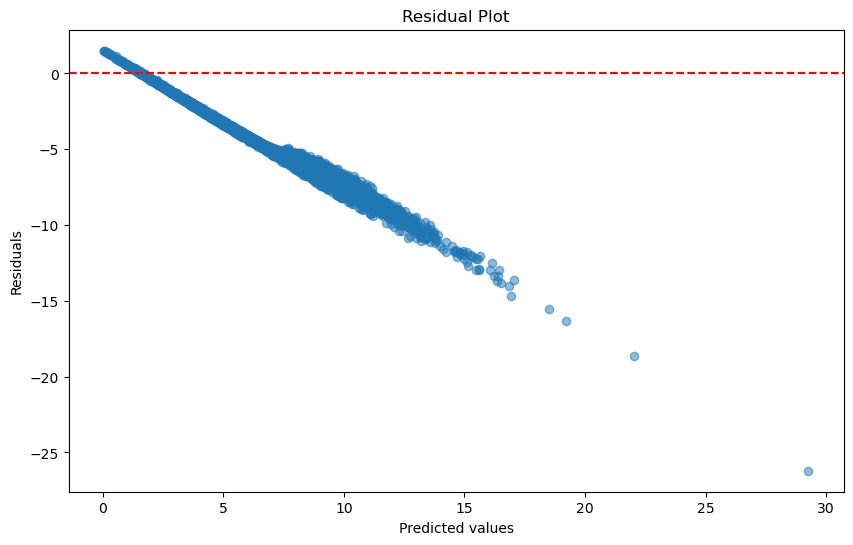

In [125]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

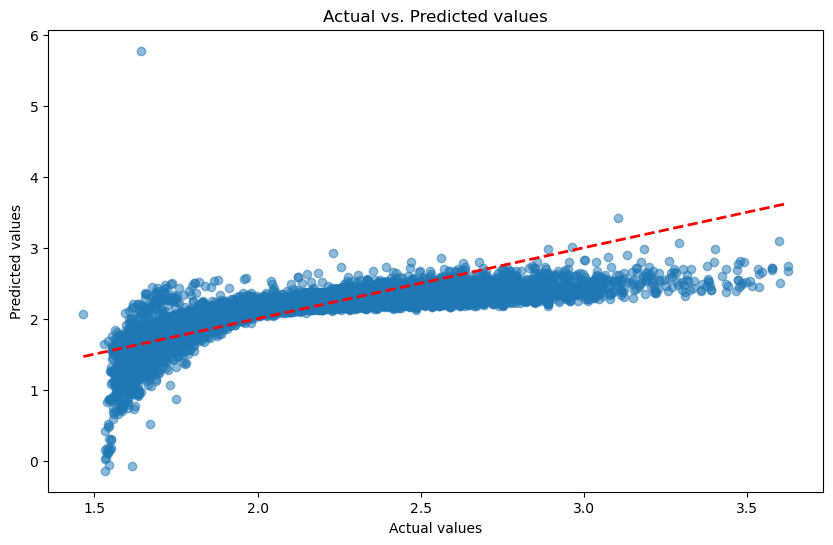

In [109]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. Predicted values')
plt.show()

In [59]:
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    model, X_poly, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation of training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

KeyboardInterrupt: 

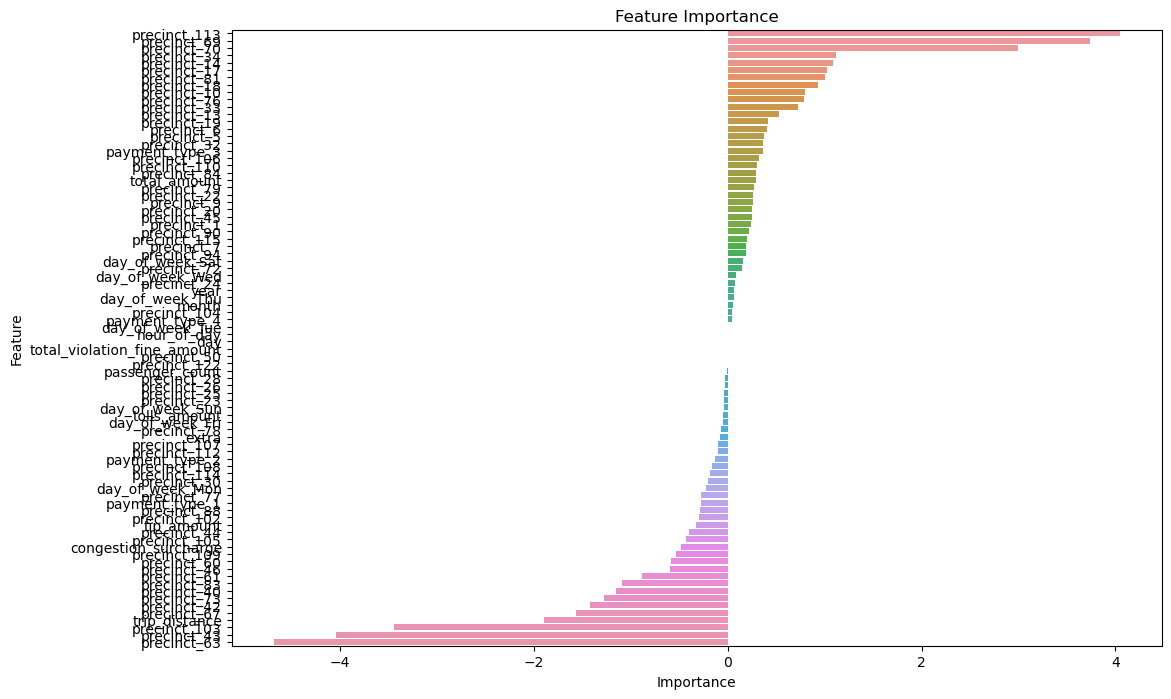

In [35]:
import seaborn as sns

# Get feature importances from coefficients
importance = model.coef_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()